In [1]:
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.7 MB/s eta 0:00:00


In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from datasets import Dataset
from tqdm.notebook import tqdm
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
projection_df = pd.read_csv('/content/CommitmentBank-items.csv')
projection_df.head(5)

,Unnamed: 0,uID,Verb,Embedding,Context,Target,Prompt,ModalType,MatTense,MatSubjLemma,MatSubjPer,MatSubjNum,Embedding.1,genre,factive,mean.noTarget,sd.noTarget,Mean,SD,Reponses
0,1,BNC-1,admit,conditional,Polly had to think quickly.,They were still close enough to shore for him ...,Polly was not an experienced ocean sailor,NaN,future,she,third,singular,conditional,BNC,no,-0.111111,1.269296,2.000000,0.866025,"2, 3, 3, 1, 3, 1, 2, 1, 2"
1,2,BNC-1002,say,modal,"Nevertheless, life went on as it always does. ...",Indeed it could be said that they had prospered.,the Kiwi Keith and the Mackenzie houses had pr...,CI,present,it,third,singular,modal,BNC,no,1.200000,1.873796,1.875000,0.834523,"2, 1, 3, 1, 2, 2, 3, 1"
2,3,BNC-1003,say,modal,"He patted her hand. If he had chosen to, Thoma...",He might have said to her that some time in th...,some time in the middle of the nineteenth cent...,AB,present,he,third,singular,modal,BNC,no,-0.250000,0.462910,0.666667,1.154701,"2, 0, 1, 0, 0, 3, -1, 0, 1, 0, 0, 2"
3,4,BNC-1005,say,modal,She could see his distorted image in the slant...,Of course she could say it was for the childre...,it was for the children,AB,future,she,third,singular,modal,BNC,no,0.636364,1.120065,0.875000,0.991031,"2, 1, 0, 1, -1, 1, 1, 2"
4,5,BNC-1006,say,modal,"She glanced around the room, laying her hot fl...",Robyn swallowed and took a deep breath trying ...,it was all right,AB,future,she,third,singular,modal,BNC,no,-1.090909,1.044466,0.000000,2.309401,"3, 1, -2, -3, -3, 3, 2, 1, -1, -1"


In [4]:
projection_df.groupby(['Verb', 'Embedding']).mean('Mean')['Mean'].unstack()[['conditional', 'modal', 'negation', 'question']].dropna()

Embedding,conditional,modal,negation,question
Verb,,,,
admit,2.000000,1.754630,-0.222222,0.555556
assume,0.666667,0.923160,0.076923,-0.895833
believe,-0.908333,1.053363,-0.974987,-1.210748
feel,0.385417,1.247917,-1.496759,-0.060185
find,0.796296,1.150309,-1.888889,0.804293
hear,1.138889,1.677778,-0.141667,0.500000
imagine,-1.319444,-0.296627,0.063889,-1.555556
know,1.318448,1.658520,0.297233,2.145425
mean,1.038194,0.799405,-1.156705,0.620370


In [5]:
projection_df.groupby(['Verb', 'Embedding']).mean('Mean')['Mean'].unstack()[['conditional', 'modal', 'negation', 'question']].dropna().mean()

,0
Embedding,
conditional,0.394511
modal,1.175340
negation,-0.331444
question,0.127327


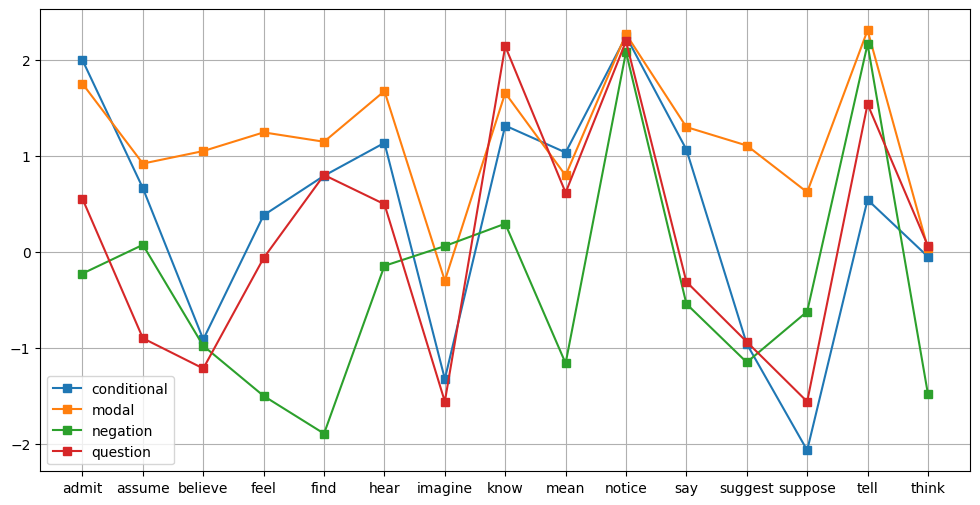

In [8]:
plt.figure(figsize=(12, 6))

plt.plot(projection_df.groupby(['Verb', 'Embedding']).mean('Mean')['Mean'].unstack()[['conditional', 'modal', 'negation', 'question']].dropna(),
         label=['conditional', 'modal', 'negation', 'question'], marker = 's')

plt.legend()
plt.xticks()
plt.grid()
plt.show()

In [10]:
projection_df.loc[projection_df['Mean'] >= 1, 'Label'] = 'Entailment'
projection_df.loc[(-1 < projection_df['Mean']) & (projection_df['Mean'] < 1), 'Label'] = 'Neutral'
projection_df.loc[projection_df['Mean'] <= -1, 'Label'] = 'Contradiction'

In [11]:
projection_df_bert = projection_df[['Target', 'Prompt', 'Label']].dropna()

In [12]:
projection_df_bert

,Target,Prompt,Label
0,They were still close enough to shore for him ...,Polly was not an experienced ocean sailor,Entailment
1,Indeed it could be said that they had prospered.,the Kiwi Keith and the Mackenzie houses had pr...,Entailment
2,He might have said to her that some time in th...,some time in the middle of the nineteenth cent...,Neutral
3,Of course she could say it was for the childre...,it was for the children,Neutral
4,Robyn swallowed and took a deep breath trying ...,it was all right,Neutral
...,...,...,...
1195,Twenty percent don't even feel they are financ...,they are financially well off,Contradiction
1196,This does not mean that the Federal Reserve do...,the Federal Reserve does not already play an i...,Neutral
1197,"In a letter, prosecutors told Mr. Antar's lawy...",any fees collected from Mr. Antar may be seized,Entailment
1198,And although Warner has said it wanted the pro...,the relationship could be repaired after the a...,Contradiction


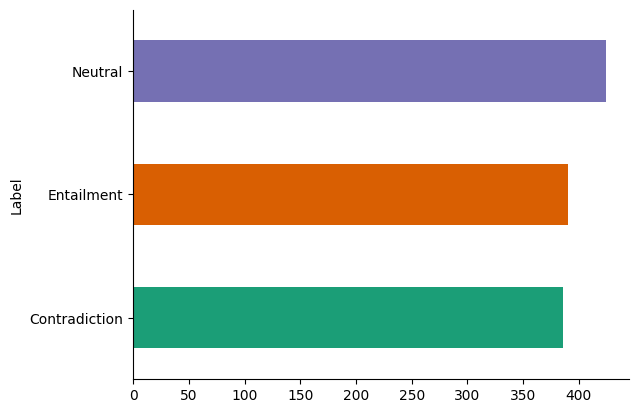

In [16]:
projection_df_bert.groupby('Label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [17]:
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [18]:
model = AutoModel.from_pretrained("FacebookAI/roberta-base")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
train_dataset = Dataset.from_pandas(projection_df_bert)

In [20]:
def vectorize_dataset_and_return(data):
    res = []
    for batch in tqdm(data):
        toks = tokenizer(batch['Target'], batch['Prompt'], padding='max_length', truncation=True, return_tensors='pt',
          max_length=64)
        with torch.no_grad():
            model_output = model(**{k: v.to(model.device) for k, v in toks.items()})
        res.append(torch.mean(model_output.last_hidden_state, dim=1))
    res = torch.vstack(res)
    return res.detach().cpu().numpy()

In [21]:
dl = DataLoader(train_dataset, batch_size=256, shuffle=False,
                drop_last=False)
vecs = vectorize_dataset_and_return(dl)
vecs.shape

  0%|          | 0/5 [00:00<?, ?it/s]

(1200, 768)

In [22]:
le = LabelEncoder()
le.fit(train_dataset['Label'])
lbl = le.transform(train_dataset['Label'])

In [23]:
x_train, x_test, y_train, y_test = train_test_split(vecs, lbl, test_size=0.33, random_state=42)

In [24]:
clf = MLPClassifier(random_state=1, max_iter=300, verbose=1)
clf.fit(x_train, y_train)

Iteration 1, loss = 1.13556701
Iteration 2, loss = 1.05597465
Iteration 3, loss = 0.99603132
Iteration 4, loss = 0.96199940
Iteration 5, loss = 0.95469053
Iteration 6, loss = 0.94910559
Iteration 7, loss = 0.90287405
Iteration 8, loss = 0.89431711
Iteration 9, loss = 0.87776940
Iteration 10, loss = 0.85722559
Iteration 11, loss = 0.84857519
Iteration 12, loss = 0.85029314
Iteration 13, loss = 0.84114837
Iteration 14, loss = 0.81812322
Iteration 15, loss = 0.80585049
Iteration 16, loss = 0.79823449
Iteration 17, loss = 0.79625587
Iteration 18, loss = 0.78954689
Iteration 19, loss = 0.78471301
Iteration 20, loss = 0.78184809
Iteration 21, loss = 0.76368968
Iteration 22, loss = 0.75313451
Iteration 23, loss = 0.74241872
Iteration 24, loss = 0.73503168
Iteration 25, loss = 0.73193851
Iteration 26, loss = 0.73509845
Iteration 27, loss = 0.72116596
Iteration 28, loss = 0.72593567
Iteration 29, loss = 0.72014153
Iteration 30, loss = 0.71867668
Iteration 31, loss = 0.71527661
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(max_iter=300, random_state=1, verbose=1)

In [25]:
train_pred = clf.predict(x_train)
test_pred = clf.predict(x_test)

In [26]:
crep = classification_report(y_train, train_pred, target_names=le.classes_)
print(crep)

               precision    recall  f1-score   support

Contradiction       0.90      1.00      0.94       260
   Entailment       0.98      0.99      0.99       272
      Neutral       0.99      0.88      0.93       272

     accuracy                           0.95       804
    macro avg       0.96      0.95      0.95       804
 weighted avg       0.96      0.95      0.95       804



In [27]:
crep = classification_report(y_test, test_pred, target_names=le.classes_)
print(crep)

               precision    recall  f1-score   support

Contradiction       0.65      0.80      0.72       126
   Entailment       0.62      0.69      0.66       118
      Neutral       0.69      0.49      0.58       152

     accuracy                           0.65       396
    macro avg       0.65      0.66      0.65       396
 weighted avg       0.66      0.65      0.64       396

